In [17]:
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from Rock.Model.MDN_From_Kaggle import mdn, Mixture
from Rock.Utils.View import init_weights
from sklearn.metrics import r2_score
import math
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.pylab import rcParams
%matplotlib inline

In [18]:
rcParams['figure.figsize'] = 7.2, 5.4

In [3]:
data = pd.read_excel('D:\\Resource\\Gas_Giants_Core_Earth20W.xlsx')
data['M_total (M_E)'] = data['Mcore (M_J/10^3)'] + data['Menv (M_E)']

input_parameters = [
    'Mass (M_J)',
    'Radius (R_E)',
    'T_sur (K)',
]

output_parameters = [
    'M_total (M_E)',
    'T_int (K)',
    'P_CEB (Mbar)',
    'T_CEB (K)'
]

scaler_x = MinMaxScaler(feature_range=[0, 1])
scaler_y = MinMaxScaler(feature_range=[0, 1])

data_x_nor = pd.DataFrame(scaler_x.fit_transform(data.loc[:, input_parameters]))
data_y_nor = pd.DataFrame(scaler_y.fit_transform(data.loc[:, output_parameters]))

In [4]:
input_size = 3
output_size = 4
n_gaussian = 10
hidden_size = 128

mixture = Mixture()

model = mdn(input_size, output_size, n_gaussian, hidden_size)
init_weights(model)
model = nn.DataParallel(model)
model.to("cuda")
model.load_state_dict(torch.load("D:\\Resource\\MDN\\model_best_mdn_normalization_4060Ti_0.97_0.0008.pth"))

test_x = np.load("D:\\Resource\\MDN\\TestData\\test_x.npy")
test_y = np.load("D:\\Resource\\MDN\\TestData\\test_y.npy")
y_label = np.arange(0, 1, 0.001).reshape(-1, 1)

model.eval()
# Predict
pi, mu, sigma = model(torch.from_numpy(test_x))

# Construct Distribution Function
normal, pi_idx, mu_selected, sigma_selected = mixture(pi, mu, sigma, 'test')

In [5]:
samples = normal.sample()

In [6]:
pis = pi[torch.arange(pi.shape[0]), pi_idx].detach().cpu().numpy()
mus = mu_selected.detach().cpu().numpy()
sigmas = sigma_selected.detach().cpu().numpy()

In [27]:
# Fixed Begin
factors = 1 / math.sqrt(2 * math.pi) / sigmas[:, 0]
exponent = np.exp(-1 / 2 * np.square((y_label - mus[:, 0]) / sigmas[:, 0]))
GMM_PDF = pis * factors * exponent
GMM_PDF_reshape = GMM_PDF.T
MM = MinMaxScaler(feature_range=[0, 1])
GMM_PDF_scaled = MM.fit_transform(GMM_PDF_reshape)
# Fix End

In [8]:
test_y_inverse = scaler_y.inverse_transform(test_y)

In [28]:
cmap = plt.cm.hot_r
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)

<Figure size 720x720 with 0 Axes>

(9.2962, 1060.2584)

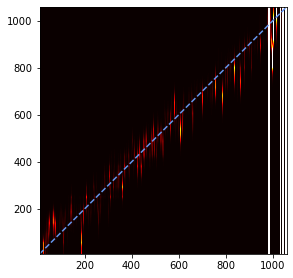

In [31]:
fig = plt.figure(figsize=(10, 10))
y = test_y_inverse[:, 0]
y_max_2 = max(y)
y_min_2 = min(y)
ax = fig.add_subplot(2, 2, 0 + 1)
for i in range(len(test_y_inverse)):
    tx = test_y_inverse[i, 0]
    ax.imshow(
        GMM_PDF_scaled[i, :].reshape(-1, 1),
        cmap=cmap,
        norm=norm,
        origin='lower',
        extent=(tx, tx + 0.5, y_min_2, y_max_2)
    )
ax.plot([y_min_2, y_max_2], [y_min_2, y_max_2], c='cornflowerblue', ls='--')

plt.axis('square')
ax.set_xlim(y_min_2, y_max_2)
ax.set_ylim(y_min_2, y_max_2)
# plt.show()